# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [159]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector


In [160]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [162]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [163]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [164]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.1 Read the Train and Test Data

In [165]:
train_X = load_dataset(context, 'train/X_train')
train_Y = load_dataset(context, 'train/Y_train')
print(train_X.shape, train_Y.shape)

test_X = load_dataset(context, 'test/X_test')
test_Y = load_dataset(context, 'test/Y_test')
print(test_X.shape, test_Y.shape)

(1716, 5) (1716, 1)
(440, 5) (440, 1)


## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [166]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [167]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(1716, 5)
(1716, 5)


In [168]:
train_X

,claim_id,Year,system_calendar_date,total_post,search_volume
0,8.0,2016,01,1124.0,53156.0
1,8.0,2016,02,1481.0,43618.0
2,8.0,2016,03,1372.0,55698.0
3,8.0,2016,04,1887.0,48196.0
4,8.0,2016,05,1617.0,53537.0
...,...,...,...,...,...
2058,438.0,2018,48,2000.0,89480.0
2059,438.0,2018,49,2577.0,75909.0
2060,438.0,2018,50,1462.0,72598.0
2061,438.0,2018,51,2134.0,79315.0


## Dropping Year and Week columns
**Year and weeks are not important parameter for model building so we are dropping those columns**

In [169]:
train_X.drop(['Year','system_calendar_date'],axis=1,inplace=True)

In [170]:
train_X

,claim_id,total_post,search_volume
0,8.0,1124.0,53156.0
1,8.0,1481.0,43618.0
2,8.0,1372.0,55698.0
3,8.0,1887.0,48196.0
4,8.0,1617.0,53537.0
...,...,...,...
2058,438.0,2000.0,89480.0
2059,438.0,2577.0,75909.0
2060,438.0,1462.0,72598.0
2061,438.0,2134.0,79315.0


In [171]:
test_X.drop(['Year','system_calendar_date'],axis=1,inplace=True)

In [172]:
test_X

,claim_id,total_post,search_volume
155,8,2267.0,66325.0
156,8,6003.0,82775.0
157,8,14076.0,74455.0
158,8,4184.0,69790.0
159,8,2475.0,71456.0
...,...,...,...
2097,438,2089.0,101006.0
2098,438,1695.0,99037.0
2099,438,1967.0,91577.0
2100,438,1420.0,41360.0


## Creating Dummies for categorical value claim_id and dropping the claim id

In [173]:
claim_dummies_train=pd.get_dummies(train_X['claim_id'],drop_first=True)

In [174]:
claim_dummies_train

,75.0,81.0,151.0,152.0,158.0,187.0,227.0,228.0,430.0,438.0
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2058,0,0,0,0,0,0,0,0,0,1
2059,0,0,0,0,0,0,0,0,0,1
2060,0,0,0,0,0,0,0,0,0,1
2061,0,0,0,0,0,0,0,0,0,1


In [175]:
train_X=pd.concat([train_X,claim_dummies_train],axis=1)

In [176]:
train_X.drop('claim_id',axis=1,inplace=True)

In [177]:
train_X

,total_post,search_volume,75.0,81.0,151.0,152.0,158.0,187.0,227.0,228.0,430.0,438.0
0,1124.0,53156.0,0,0,0,0,0,0,0,0,0,0
1,1481.0,43618.0,0,0,0,0,0,0,0,0,0,0
2,1372.0,55698.0,0,0,0,0,0,0,0,0,0,0
3,1887.0,48196.0,0,0,0,0,0,0,0,0,0,0
4,1617.0,53537.0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2058,2000.0,89480.0,0,0,0,0,0,0,0,0,0,1
2059,2577.0,75909.0,0,0,0,0,0,0,0,0,0,1
2060,1462.0,72598.0,0,0,0,0,0,0,0,0,0,1
2061,2134.0,79315.0,0,0,0,0,0,0,0,0,0,1


In [178]:
claim_dummies_test=pd.get_dummies(test_X['claim_id'],drop_first=True)

In [179]:
claim_dummies_test

,75,81,151,152,158,187,227,228,430,438
155,0,0,0,0,0,0,0,0,0,0
156,0,0,0,0,0,0,0,0,0,0
157,0,0,0,0,0,0,0,0,0,0
158,0,0,0,0,0,0,0,0,0,0
159,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2097,0,0,0,0,0,0,0,0,0,1
2098,0,0,0,0,0,0,0,0,0,1
2099,0,0,0,0,0,0,0,0,0,1
2100,0,0,0,0,0,0,0,0,0,1


In [180]:
test_X=pd.concat([test_X,claim_dummies_test],axis=1)

In [181]:
test_X.drop('claim_id',axis=1,inplace=True)

In [182]:
test_X

,total_post,search_volume,75,81,151,152,158,187,227,228,430,438
155,2267.0,66325.0,0,0,0,0,0,0,0,0,0,0
156,6003.0,82775.0,0,0,0,0,0,0,0,0,0,0
157,14076.0,74455.0,0,0,0,0,0,0,0,0,0,0
158,4184.0,69790.0,0,0,0,0,0,0,0,0,0,0
159,2475.0,71456.0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2097,2089.0,101006.0,0,0,0,0,0,0,0,0,0,1
2098,1695.0,99037.0,0,0,0,0,0,0,0,0,0,1
2099,1967.0,91577.0,0,0,0,0,0,0,0,0,0,1
2100,1420.0,41360.0,0,0,0,0,0,0,0,0,0,1


In [183]:
lin_reg = sm.OLS(train_Y,sm.add_constant(train_X)).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     sales_dollars_value   R-squared:                       0.988
Model:                             OLS   Adj. R-squared:                  0.988
Method:                  Least Squares   F-statistic:                 1.183e+04
Date:                 Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                         17:29:58   Log-Likelihood:                -24245.
No. Observations:                 1716   AIC:                         4.852e+04
Df Residuals:                     1703   BIC:                         4.859e+04
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.934e+06   4.78e+04    145.025      0.000    6.84e+06    7.03e+06
total_post      142.4498     12.546     11.354      0.000     117.843     167.056
search_volume     2.0563      0.586      3.509      0.000       0.907       3.206
75.0          -7.033e+06   4.81e+04   -146.285      0.000   -7.13e+06   -6.94e+06
81.0          -6.971e+06   5.04e+04   -138.268      0.000   -7.07e+06   -6.87e+06
151.0         -6.993e+06   4.47e+04   -156.340      0.000   -7.08e+06   -6.91e+06
152.0         -6.968e+06   4.97e+04   -140.172      0.000   -7.07e+06   -6.87e+06
158.0         -7.107e+06   4.58e+04   -155.065      0.000    -7.2e+06   -7.02e+06
187.0         -6.541e+06    4.6e+04   -142.168      0.000   -6.63e+06   -6.45e+06
227.0          2.512e+05   4.83e+04      5.205      0.000    1.57e+05    3.46e+05
228.0         -6.978e+06   5.13e+04   -135.990      0.000   -7.08e+06   -6.88e+06
430.0         -7.225e+05   5.31e+04    -13.602      0.000   -8.27e+05   -6.18e+05
438.0          -5.62e+06   4.17e+04   -134.795      0.000    -5.7e+06   -5.54e+06
==============================================================================
Omnibus:                      380.595   Durbin-Watson:                   0.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8522.219
Skew:                          -0.459   Prob(JB):                         0.00
Kurtosis:                      13.879   Cond. No.                     6.69e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [184]:
def performance(train_X,train_Y, test_X,test_Y):
    lin_reg = sm.OLS(train_Y,sm.add_constant(train_X)).fit()
    train_Y_pred =  lin_reg.predict(sm.add_constant(train_X))
    test_Y_pred =  lin_reg.predict(sm.add_constant(test_X))
    print('Train R2',r2_score(train_Y,train_Y_pred))
    print('Test R2',r2_score(test_Y,test_Y_pred))
    print('-'*50)
    print('Train MAPE:', mean_absolute_percentage_error(train_Y,train_Y_pred))
    print('Test MAPE:', mean_absolute_percentage_error(test_Y,test_Y_pred))
    print('Cross Val Score of MAPE:')
    scores = -1*cross_val_score(LinearRegression(),train_X,train_Y,cv=5,
                scoring='neg_mean_absolute_percentage_error')
    bias  = np.mean(scores)
    variance = np.std(scores,ddof=1)
    print('CV_scores:',scores)
    print('Bias :',bias)
    print('Variance:',variance)

In [185]:
performance(train_X,train_Y,test_X,test_Y)

Train R2 0.9881476482444833
Test R2 0.9741988158863216
--------------------------------------------------
Train MAPE: 6.931288778464521
Test MAPE: 6.743817934721071
Cross Val Score of MAPE:
CV_scores: [61.822295   39.81740822 47.9400386  27.76714199 10.95622561]
Bias : 37.66062188592591
Variance: 19.39787557917059


Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all st

<AxesSubplot:>

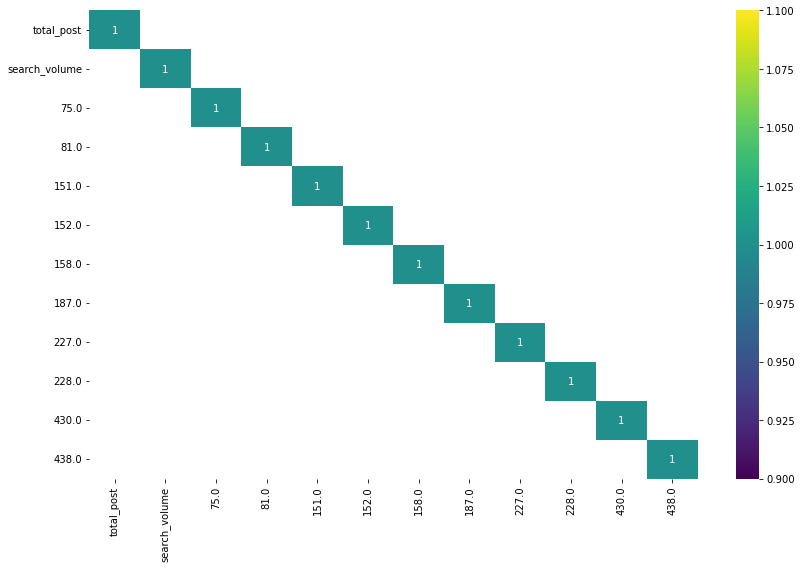

In [186]:
corr = train_X.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr[corr>=.8],annot=True,cmap='viridis')

# VIF

In [187]:
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

In [188]:
ft=[]
vif_val = 10
x =train_X[num_columns]
collinear_ft = []
vif_max = 100
while vif_max>vif_val:
    x_vif = sm.add_constant(x.drop(columns=collinear_ft))
    vif = pd.DataFrame()
    vif['VIF']=[variance_inflation_factor(x_vif.values,i) for i in range(x_vif.shape[1])]
    vif['features']=x_vif.columns
    vif = vif.sort_values(by='VIF',ascending=False).reset_index(drop=True)
    if vif.loc[0,'features']!='const':
        vif_max = vif.loc[0,'VIF']
        collinear_ft.append(vif.loc[0,'features'])
    else:
        vif_max = vif.loc[1,'VIF']
        collinear_ft.append(vif.loc[1,'features'])
vif_feat = list(vif['features'])
vif_feat.remove('const')
print(vif_feat)

['search_volume', 430.0, 228.0, 81.0, 152.0, 227.0, 75.0, 187.0, 158.0, 151.0, 'total_post', 438.0]


In [189]:
X_train_num = train_X[vif_feat]
X_test_num = test_X[vif_feat]

In [190]:
lin_reg = sm.OLS(train_Y,sm.add_constant(X_train_num)).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     sales_dollars_value   R-squared:                       0.988
Model:                             OLS   Adj. R-squared:                  0.988
Method:                  Least Squares   F-statistic:                 1.183e+04
Date:                 Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                         17:30:06   Log-Likelihood:                -24245.
No. Observations:                 1716   AIC:                         4.852e+04
Df Residuals:                     1703   BIC:                         4.859e+04
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.934e+06   4.78e+04    145.025      0.000    6.84e+06    7.03e+06
search_volume     2.0563      0.586      3.509      0.000       0.907       3.206
430.0         -7.225e+05   5.31e+04    -13.602      0.000   -8.27e+05   -6.18e+05
228.0         -6.978e+06   5.13e+04   -135.990      0.000   -7.08e+06   -6.88e+06
81.0          -6.971e+06   5.04e+04   -138.268      0.000   -7.07e+06   -6.87e+06
152.0         -6.968e+06   4.97e+04   -140.172      0.000   -7.07e+06   -6.87e+06
227.0          2.512e+05   4.83e+04      5.205      0.000    1.57e+05    3.46e+05
75.0          -7.033e+06   4.81e+04   -146.285      0.000   -7.13e+06   -6.94e+06
187.0         -6.541e+06    4.6e+04   -142.168      0.000   -6.63e+06   -6.45e+06
158.0         -7.107e+06   4.58e+04   -155.065      0.000    -7.2e+06   -7.02e+06
151.0         -6.993e+06   4.47e+04   -156.340      0.000   -7.08e+06   -6.91e+06
total_post      142.4498     12.546     11.354      0.000     117.843     167.056
438.0          -5.62e+06   4.17e+04   -134.795      0.000    -5.7e+06   -5.54e+06
==============================================================================
Omnibus:                      380.595   Durbin-Watson:                   0.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8522.219
Skew:                          -0.459   Prob(JB):                         0.00
Kurtosis:                      13.879   Cond. No.                     6.69e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [191]:
performance(X_train_num,train_Y,X_test_num,test_Y)

Train R2 0.9881476482444833
Test R2 0.9741988158863004
--------------------------------------------------
Train MAPE: 6.931288778514695
Test MAPE: 6.743817934752695
Cross Val Score of MAPE:
CV_scores: [61.822295   39.81740822 47.9400386  27.76714199 10.95622561]
Bias : 37.660621885923405
Variance: 19.397875579171682


Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
Feature names only support names that are all st

Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels.
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code